In [2]:
import os

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [3]:
DATA_DIR = r"C:\Users\denis\PycharmProjects\recsys-course-spring-2025\rec_sys_data\week_4"

In [4]:
# data = pd.concat([
#     pd.read_json(data_path, lines=True) 
#     for data_path 
#     # in glob.glob(DATA_DIR + "/data/*/data.json")
#     in glob.glob(r"C:\Users\denis\PycharmProjects\recsys-course-spring-2025\rec_sys_data\week_4\*\data.json")
# ])
# data["rnd"] = np.random.random(len(data))
# 
# data.head(5)

In [5]:
wsl_path = "/mnt/c/Users/denis/PycharmProjects/recsys-course-spring-2025/rec_sys_data/week_4/*/data.json"
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path in glob.glob(os.path.expanduser(wsl_path))
])

In [6]:
len(data)

766478

In [7]:
positives = data[data["time"] > 0.7].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7
positives.drop_duplicates(["user", "track"], inplace=True)

In [8]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 4].index.values)

In [9]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 4].index.values)

In [10]:
len(users), len(tracks)

(9692, 10905)

## Train LightFM

In [11]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(64950, 20897)

In [12]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [13]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [17]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        # print(f"Epoch {epoch} started")
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopping!")
            break
        
    else:
        if verbose:
            print("No early stopping happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
        threads=30
    )
    
    return precisions_at[-1]

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2025-03-17 23:39:06,658] A new study created in memory with name: no-name-35e4e22f-080d-4578-ae38-4d3c72b10f1f
[I 2025-03-17 23:39:16,180] Trial 0 finished with value: 0.000342465762514621 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.000342465762514621.
[I 2025-03-17 23:39:23,392] Trial 1 finished with value: 0.00019569472351577133 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.000342465762514621.
[I 2025-03-17 23:39:31,387] Trial 2 finished with value: 0.0001712328812573105 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.000342465762514621.
[I 2025-03-17 23:39:36,877] Trial 3 finished with value: 0.00199363986030221 and pa

In [19]:
best_params

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.01,
 'max_sampled': 100,
 'user_alpha': 0.0001,
 'item_alpha': 0.0001}

In [20]:
best_params = {
    'loss': 'warp',
    'no_components': 30,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0001,
    'item_alpha': 0.0001
}

In [21]:
model, precisions_at = fit_model(
    epochs=300,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.0018101762980222702 +/- 0.00030260642905668896
1:	0.001797945355065167 +/- 0.00030168964732112363
2:	0.0017734833527356386 +/- 0.000297923944085405
3:	0.0017857142956927419 +/- 0.00029692332304065937
4:	0.0018468688940629363 +/- 0.0003034507169422023
5:	0.0018957925494760275 +/- 0.00030707547000775556
6:	0.002054794691503048 +/- 0.00032034592247252516
7:	0.002397260395810008 +/- 0.0003517751658372807
8:	0.002947651781141758 +/- 0.000408190562290372
9:	0.003375733969733119 +/- 0.00044120298170710035
10:	0.0038282780442386866 +/- 0.00047769042239159963
11:	0.0042808218859136105 +/- 0.0005080111013486944
12:	0.004672211594879627 +/- 0.0005296870249537134
13:	0.005051370244473219 +/- 0.0005540748362927611
14:	0.005442759487777948 +/- 0.0005777599962965504
15:	0.005711839534342289 +/- 0.0005922739070442378
16:	0.006152153015136719 +/- 0.000611246946606992
17:	0.006384540349245071 +/- 0.0006263945880538816
18:	0.006837084423750639 +/- 0.0006480899321779066
19:	0.007228473667055368 +/- 0

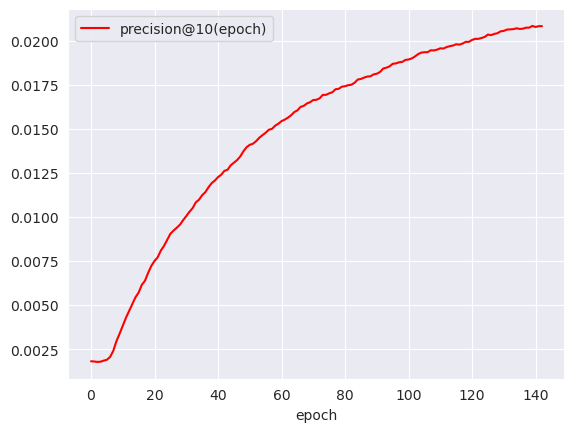

In [22]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Save track embeddings

In [23]:
BOTIFY_DATA_DIR = "/mnt/c/Users/denis/PycharmProjects/recsys-course-spring-2025/botify/data/"

In [24]:
biases, embeddings = model.get_item_representations()

In [25]:
model.item_biases *= 0.0

In [26]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [27]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [28]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [29]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [30]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-30:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 9692/9692 [00:16<00:00, 583.24it/s]
